### Train and Test Images have been annotated using Imagelab.in and a **40_imaglab.xml** for all the images has been obtained.

In [1]:
import config as cf

### Copying the files in train_data and test_data in the train and test directories respectively

In [2]:
# import os
# import shutil

# def copy_files(data,to_dir):
#     for image_name in data.image.unique():
#         src = os.path.join(cf.image_input_dir, image_name+".jpeg")
#         dst = os.path.join(to_dir,image_name+".jpeg")
#         shutil.copyfile(src, dst)
        
# copy_files(train_data,cf.train_dir)
# copy_files(test_data,cf.test_dir)

### Text in the images can be extracted using OCR[Optical Character Recognition], for this there are multiple methods like keras OCR and pytesseract for this problem we will use tesseract module.

In [3]:
def create_extracted_text_df(img_path):
    """
    This function extracts text from the image at the given path and creates a DataFrame
    with two columns: 'text' and 'Image_name'.

    Args:
        img_path (str): Path of the image.

    Returns:
        DataFrame: A DataFrame with two columns: 'text' and 'Image_name'. 
                   'text' column contains the extracted text from the image 
                   and 'Image_name' column contains the name of the image.
    """
    text = cf.pytesseract.image_to_string(img_path)
    text_df = cf.pd.DataFrame(text.splitlines(), columns=['text'])
    text_df = text_df[text_df['text'] != ''].reset_index(drop=True)
    text_df['Image_name'] = img_path.split('/')[-1]
    
    return text_df


def word_box_df_create(img_path: str) -> cf.pd.DataFrame:
    """
    This function creates a DataFrame for every word in the given image with its
    box coordinates, word number, page number, and more.

    Args:
        img_path (str): Path of the image.

    Returns:
        pd.DataFrame: A DataFrame with columns 'level', 'page_num', 'block_num', 'par_num',
        'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', and 'text'.
        Each row in the DataFrame represents a word and its corresponding attributes.
    """
    box_data = cf.pytesseract.image_to_data(img_path, output_type=cf.pytesseract.Output.DICT)
    attributes = ['level','page_num','block_num','par_num','line_num','word_num','left','top','width','height','conf','text']

    df = cf.pd.DataFrame(box_data, columns=attributes)

    # Drop rows with empty or single-space text
    df = df[(df['text'] != '') & (df['text'] != ' ')]
    
    return df


def sentecne_box_df_create(dt, text):
    """Combines the output from the `word_box_df_create()` and `create_extracted_text_df()` 
    functions to create a new dataframe for the box locations for all the sentences in the image.

    Args:
        dt (DataFrame): DataFrame returned from `word_box_df_create()`
        text (DataFrame): DataFrame returned from `create_extracted_text_df()`

    Returns:
        DataFrame: DataFrame with box locations of the sentences in image
    """
    sentence_df = cf.pd.DataFrame(columns=['text', 'left', 'top', 'width', 'height', 'Image_name'])

    for i in range(len(text)):
        sentence_text = text.iloc[i]['text']
        sentence_left, sentence_top, sentence_width, sentence_height = [], [], [], []

        for j in range(dt.shape[0]):
            word_text = dt.iloc[j]['text']

            if sentence_text.startswith(word_text):
                sentence_left.append(int(dt.iloc[j]['left']))
                sentence_top.append(int(dt.iloc[j]['top']))
                sentence_width.append(int(dt.iloc[j]['width']))
                sentence_height.append(int(dt.iloc[j]['height']))

                sentence_text = sentence_text[len(word_text):].strip()

                if len(sentence_text) == 0:
                    new_sentence = cf.pd.DataFrame({
                        'text': [text.iloc[i]['text']],
                        'left': [min(sentence_left)],
                        'top': [min(sentence_top)],
                        'width': [sum(sentence_width)],
                        'height': [max(sentence_height)],
                        'Image_name': [text.iloc[i]['Image_name']]
                    })
                    sentence_df = cf.pd.concat([sentence_df, new_sentence], ignore_index=True)

                    break

    return sentence_df



train_images = cf.glob.glob(cf.train_dir + "/*.jpeg")
first_image_text = create_extracted_text_df(train_images[0])



train_images = cf.glob.glob(cf.train_dir + "/*.jpeg")
first_image_word_boxes = word_box_df_create(train_images[0])


dt = word_box_df_create(train_images[0])
text = create_extracted_text_df(train_images[0])

sentecne_box_df_create(dt,text)

,text,left,top,width,height,Image_name
0,P.O. BOX 2000 - ANAHEIM - CA 92803,261,173,196,10,129.jpeg
1,(714) 937-6700,331,187,80,11,129.jpeg
2,"DATE: March 18, 1986",397,229,116,11,129.jpeg
3,INVOICE NO: PSM-3,397,257,110,10,129.jpeg
4,TERMS: Net- 10 days,396,276,165,28,129.jpeg
5,INVOICE,397,257,52,10,129.jpeg
6,To:,104,359,19,10,129.jpeg
7,Philip Morris - Marlboro,144,381,148,13,129.jpeg
8,120 Park Avenue,145,396,91,9,129.jpeg
9,"New York, New York 10017",144,410,139,11,129.jpeg


In [4]:
def annotated_file_dataset(dir_path):
    final_df = cf.pd.DataFrame()

    for image_file in cf.glob.glob(dir_path + "/*.jpeg"):
    # extract the text and word boxes from the image
        text_df = create_extracted_text_df(image_file)
        word_box_df = word_box_df_create(image_file)
    
    # extract sentence boxes from the word boxes and text
        sentence_box_df = sentecne_box_df_create(word_box_df, text_df)
    
    # append the sentence boxes to the final dataframe
        final_df = cf.pd.concat([final_df, sentence_box_df], ignore_index=True)
    return final_df

train_df = annotated_file_dataset(cf.train_dir)
test_df = annotated_file_dataset(cf.test_dir)

In [5]:
import xml.etree.ElementTree as ET
import pandas as pd

# Parse XML file
tree = ET.parse('40_imglab.xml')
root = tree.getroot()

# Initialize dictionary to store data
data = {'file': [], 'top': [], 'left': [], 'width': [], 'height': [], 'label': []}

# Iterate through image tags
for image in root.findall('image'):
    file = image.get('file')
    
    # Iterate through box tags
    for box in image.findall('box'):
        top = int(box.get('top'))
        left = int(box.get('left'))
        width = int(box.get('width'))
        height = int(box.get('height'))
        label = box.find('label').text
        
        # Append data to dictionary
        data['file'].append(file)
        data['top'].append(top)
        data['left'].append(left)
        data['width'].append(width)
        data['height'].append(height)
        data['label'].append(label)

# Create DataFrame from dictionary
df = pd.DataFrame(data)
df.file.nunique()

40

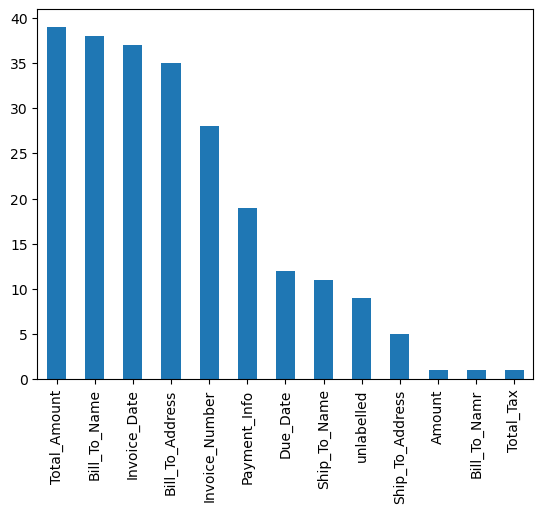

In [6]:
df.label.value_counts().plot(kind = 'bar')
cf.plt.show()

In [7]:
df = df[(df.label != 'unlabelled') & (df.label != 'Amount')]
df.loc[df.label == 'Bill_To_Namr',"label"] = "Bill_To_Name"

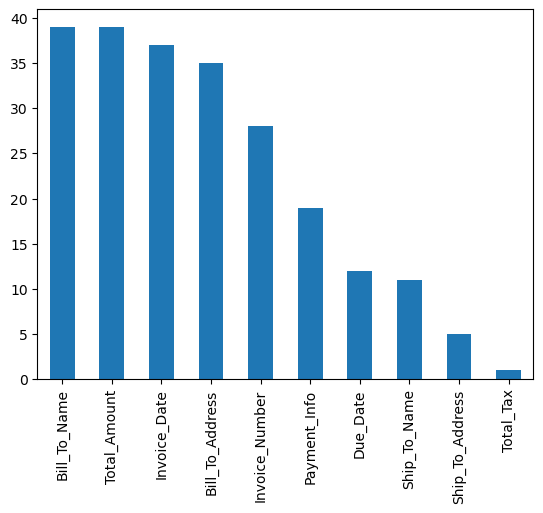

In [8]:
df.label.value_counts().plot(kind = 'bar')
cf.plt.show()

In [9]:
def get_label_words(image_dir: str, df : cf.pd.DataFrame) -> cf.pd.DataFrame:
    """
    Extracts the text from bounding boxes in an image and adds the words to a DataFrame.

    Args:
        file_path (str): The name of the file to process.
        image_dir (str): The directory where the image is located.

    Returns:
        A pandas DataFrame containing the original data with an additional column of words extracted from the image.

    """
    for file in df.file.unique():
        # Load the image
        img = cf.plt.imread(cf.os.path.join(image_dir, file))

        labelled_data = []
        # Iterate over rows in the DataFrame that match the specified file name
        for _, row in df[df.file == file].iterrows():
            box_left = int(row.left)
            box_top = int(row.top)
            box_width = int(row.width)
            box_height = int(row.height)

            # Crop the image to the bounding box
            crop_img = img[box_top:box_top+box_height, box_left:box_left+box_width]

            # Use pytesseract to extract the text from the cropped image
            pytesseract_text = cf.pytesseract.image_to_string(crop_img)
            words = ''.join(pytesseract_text).strip().lower()

            labelled_data.append(words)

        # Add the extracted words to the DataFrame
        df.loc[df.file == file, 'words'] = labelled_data

    return df


df = get_label_words(cf.image_input_dir,df)

In [10]:
def create_labelled_final_dataset(df1,df2):
    df1['label'] = pd.Series(cf.np.nan,index=range(df1.shape[0]))
    for file in df1.Image_name.unique():
        tempdf = df2[(df2.file == file) & (df2.words != "")]
        for index,row in tempdf.iterrows():
            for act_index,act_row in df1[(df1.Image_name == file) & (df1.label.isna())].iterrows():
                if ((row.words.lower() in act_row.text.lower())):
                    df1.loc[(df1.Image_name == file) & (df1.text == act_row.text),"label"] = row.label

    return df1

test_df = create_labelled_final_dataset(df1 = test_df,df2 = df)
train_df = create_labelled_final_dataset(df1 = train_df,df2 = df)

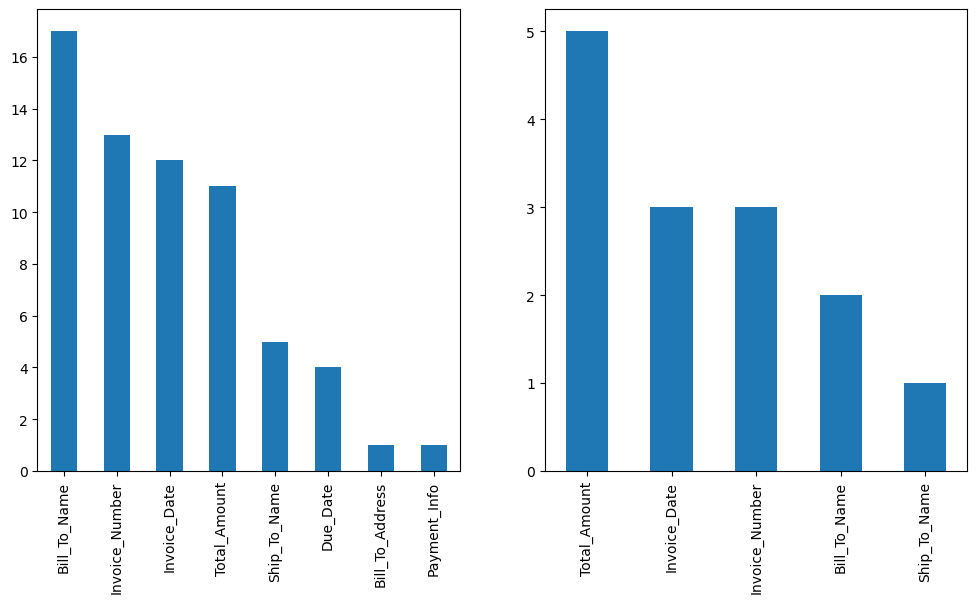

In [11]:
fig,axs = cf.plt.subplots(1,2,figsize = (12,6))
train_df.label.value_counts().plot(kind='bar',ax = axs[0])
test_df.label.value_counts().plot(kind='bar',ax = axs[1])
cf.plt.show()

In [12]:
train_df.loc[train_df.label.isna(),['label']] = 'Other'
test_df.loc[test_df.label.isna(),['label']] = 'Other'

train_df = train_df.drop(train_df[train_df['label'] == 'Other'].sample(frac=0.98).index)

In [13]:
test_df = test_df.drop(test_df[test_df['label'] == 'Other'].sample(frac=0.95).index)

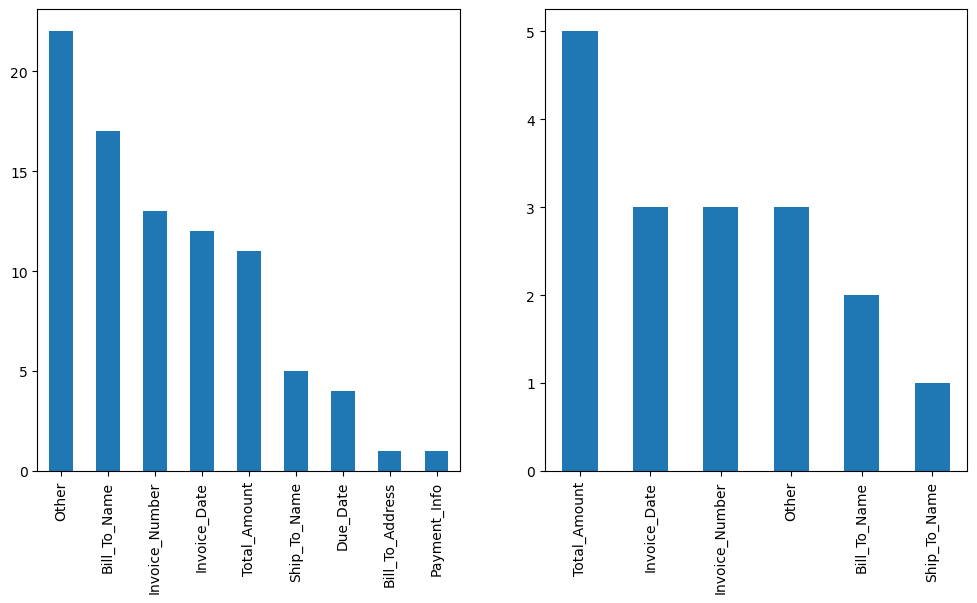

In [14]:
fig,axs = cf.plt.subplots(1,2,figsize = (12,6))
train_df.label.value_counts().plot(kind='bar',ax = axs[0])
test_df.label.value_counts().plot(kind='bar',ax = axs[1])
cf.plt.show()

In [15]:
train_df.shape,test_df.shape

((86, 7), (17, 7))

## NLP Processing

In the text preprocessing the text has been lematized then all special character except the $ sign has been removed and using the TFIDF vectoization new features have been created and fed to Random Forest Model with 300 trees.

In [51]:
def clean_doc(sent):
    doc = cf.nlp(sent)
    lemma_out = [token.lemma_ for token in doc]
    lemma_out = " ".join(lemma_out)
    return lemma_out

def preprocess(df,is_train,vectorizer=None):
    df["text_clean"] = df.text.apply(lambda x: clean_doc(x))
    df['text_clean'] = df['text_clean'].apply(lambda x : cf.re.sub('[^A-Za-z0-9 $]+','',x))
    df['has_dollar_sign'] = df['text'].apply(lambda x: 1 if '$' in x else 0)
    df['has_num'] = df['text'].apply(lambda x : 1 if bool(cf.re.search(r'\d',x)) else 0)
    df = df.reset_index(drop=True)
    
    if is_train:
        vec = cf.vec.fit(df["text_clean"])
        vectorized_data = vec.transform(df["text_clean"])
        result = pd.DataFrame(data=vectorized_data.toarray(),columns=cf.vec.get_feature_names_out())
        df = pd.concat([df,result],axis=1)
        return df,vec
    else:
        try:
            vectorized_data = vectorizer.transform(df["text_clean"])
            result = pd.DataFrame(data=vectorized_data.toarray(),columns=cf.vec.get_feature_names_out())
            df = pd.concat([df,result],axis=1)
            return df
        except:
            print('Please fit the train data first')

In [52]:
def drop_unwanted(df):
    X = df.drop(['text','text_clean','Image_name','height'],axis = 1)
    y = None
    try:
        X = X.drop(['label'],axis=1)
        y = df['label']
    except KeyError:
        pass
    
    return X,y

def train(train_df):
    train,vectorizer = preprocess(train_df,is_train=True)
    
    X,y = drop_unwanted(train)
    
    X_train, X_test, y_train, y_test = cf.train_test_split(X, y, test_size=0.3,random_state = 24)

    clf = cf.RandomForestClassifier(n_estimators=500,random_state=5)
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)
    print("Accuracy of this Training is : ",cf.accuracy_score(y_test, preds)) 
    
    return clf,vectorizer

clf,vectorizer = train(train_df)

Accuracy of this Training is :  0.6923076923076923


In [57]:
test = preprocess(test_df,is_train=False,vectorizer=vectorizer)
tst_X,tst_y = drop_unwanted(test)
pred = clf.predict(tst_X)
cf.accuracy_score(tst_y,pred)

0.7058823529411765

In [67]:
tst_X

,left,top,width,has_dollar_sign,has_num,00,02,0240,03400,047246008070855,...,total,trustees,usa,ve,vocument,way,william,worldwide,york,zaventem
0,403,189,95,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,146,518,124,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,146,530,298,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,282,646,62,1,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,146,680,254,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,49,330,101,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,565,202,96,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,438,573,107,1,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,601,155,20,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,108,253,170,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
cf.joblib.dump(clf,'Invoice_Classifier.pkl')

['Invoice_Classifier.pkl']

In [63]:
cf.joblib.dump(vectorizer,'Invoice_vectorizer.pkl')

['Invoice_vectorizer.pkl']

TfidfVectorizer(stop_words='english')

In [59]:
test_df['predic'] = pred
test_df[test_df['label'] != 'Other'][['label','predic']]

,label,predic
3,Invoice_Date,Invoice_Date
8,Invoice_Number,Invoice_Number
12,Total_Amount,Total_Amount
14,Invoice_Date,Invoice_Date
21,Bill_To_Name,Bill_To_Name
29,Invoice_Number,Invoice_Number
39,Total_Amount,Total_Amount
41,Invoice_Number,Other
44,Ship_To_Name,Bill_To_Name
51,Total_Amount,Other


## Plotting Prediction

In [60]:
cords = []
predicted_labels = []
for label in cf.Labels:
    try:
        vals = test_df[(test_df['Image_name'] == '1558.jpeg') & (test_df['label'] == label)][['left','top','width','height','predic']].values[0]
        cords.append([vals[0],vals[1],vals[2],vals[3]])
        predicted_labels.append([vals[4]])
    except IndexError:
        pass

predicted_labels

[['Invoice_Number'], ['Invoice_Date'], ['Total_Amount']]

In [61]:
test_df[test_df['Image_name'] == '501.jpeg']

,text,left,top,width,height,Image_name,label,text_clean,has_dollar_sign,has_num,predic
41,205,601,155,20,8,501.jpeg,Invoice_Number,205,0,1,Other
44,Philip Morris Philip Morris,108,253,170,12,501.jpeg,Ship_To_Name,Philip Morris Philip Morris,0,0,Bill_To_Name
51,BEH SE RNG (23000ALL00-4010- 7280832.00,164,465,235,11,501.jpeg,Total_Amount,BEH SE RNG 23000all00 4010 728083200,0,1,Other
56,"executing above program from Jan 1 - Sept 30, ...",160,556,294,30,501.jpeg,Other,execute above program from Jan 1 Sept 30 1993,0,1,Other
63,280832.00,650,882,61,9,501.jpeg,Total_Amount,28083200,0,1,Other


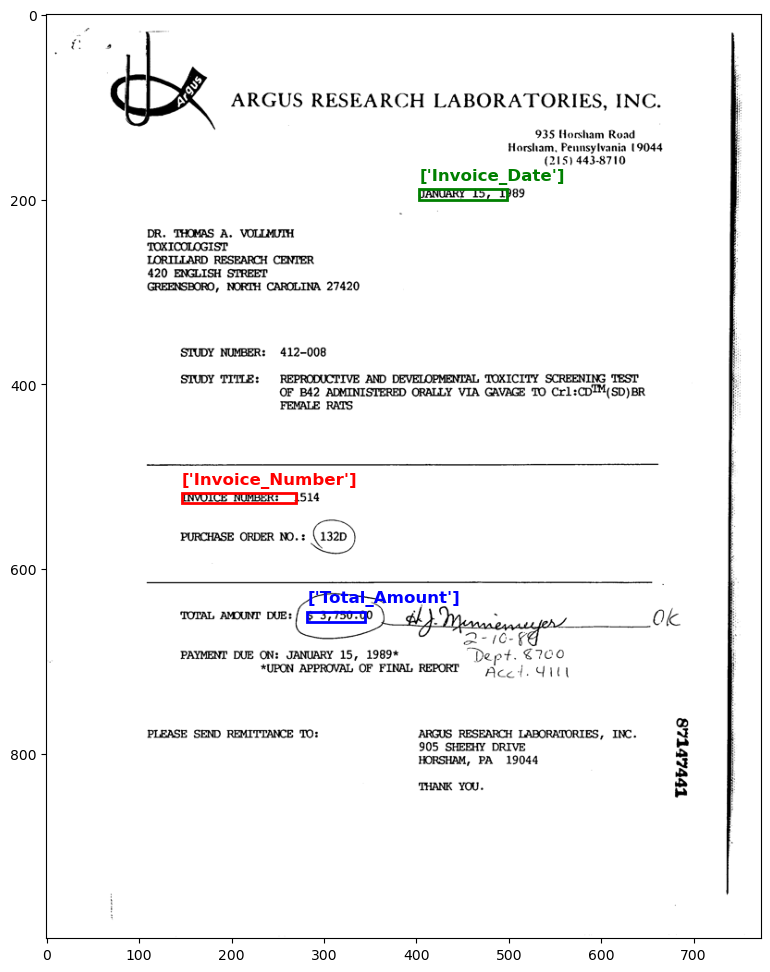

In [62]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Load the image
img = plt.imread('test/1558.jpeg')

# Create figure and axis objects
fig, ax = plt.subplots(figsize = (10,12))

# Plot the image
ax.imshow(img,cmap='gray')

# Define the coordinates and size of the rectangles
rect_coords = cords

# Define the colors and labels for the rectangles
colors = ['red', 'green', 'blue']
labels = predicted_labels

# Loop over the rectangles, plot them and add labels
for i, (x, y, width, height) in enumerate(rect_coords):
    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor=colors[i], facecolor='none')

    # Add the patch to the plot
    ax.add_patch(rect)

    # Add the label to the plot
    ax.text(x, y-10, labels[i], fontsize=12, color=colors[i], fontweight='bold')

# Display the plot
plt.show()


## Inference

In [97]:
def infer():
    infer_df = annotated_file_dataset(cf.test_dir)
    model = cf.joblib.load('Invoice_Classifier.pkl')
    vectorizer = cf.joblib.load('Invoice_vectorizer.pkl')
    
    infer = preprocess(infer_df,False,vectorizer)
    infer,y = drop_unwanted(infer)
    preds = model.predict(infer)
    
    infer_df['label'] = preds
    infer_df = infer_df[infer_df.label != 'Other']
    return infer_df

infer()    
    

,text,left,top,width,height,Image_name,text_clean,has_dollar_sign,has_num,label
1,935 Horsham Road,529,125,96,10,1558.jpeg,935 Horsham Road,0,1,Invoice_Number
2,(215) 443-8710,539,153,82,10,1558.jpeg,215 443 8710,0,1,Invoice_Number
3,"JANUARY 15, 1989",403,189,95,11,1558.jpeg,JANUARY 15 1989,0,1,Invoice_Date
4,STUDY NUMBER: 412-008,146,361,133,10,1558.jpeg,study number 412 008,0,1,Invoice_Number
8,INVOICE NUMBER: 1514,146,518,124,10,1558.jpeg,INVOICE number 1514,0,1,Invoice_Number
12,"$ 3,750.00",282,646,62,11,1558.jpeg,$ 375000,1,1,Total_Amount
14,"PAYMENT DUE ON: JANUARY 15, 1989*",146,680,254,28,1558.jpeg,PAYMENT DUE on JANUARY 15 1989,0,1,Invoice_Date
21,TO: Mr. Scott Benson,49,330,101,10,845.jpeg,to Mr Scott Benson,0,0,Bill_To_Name
22,Lorillard Tobacco Company,82,345,144,12,845.jpeg,Lorillard Tobacco Company,0,0,Bill_To_Name
23,INVOICE,307,182,88,15,845.jpeg,invoice,0,0,Invoice_Number
